# Importing Libraries and Dataset

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("C:\\Users\\vishn\\Downloads\\temperature_device_failure.csv", parse_dates=['timestamp'], index_col='timestamp')

# Features in orginal dataset

In [96]:
df.head()

,value
timestamp,
2013-07-04 00:00:00,69.880835
2013-07-04 01:00:00,71.220227
2013-07-04 02:00:00,70.877805
2013-07-04 03:00:00,68.959400
2013-07-04 04:00:00,69.283551


# Visualizing Features in Original Dataset

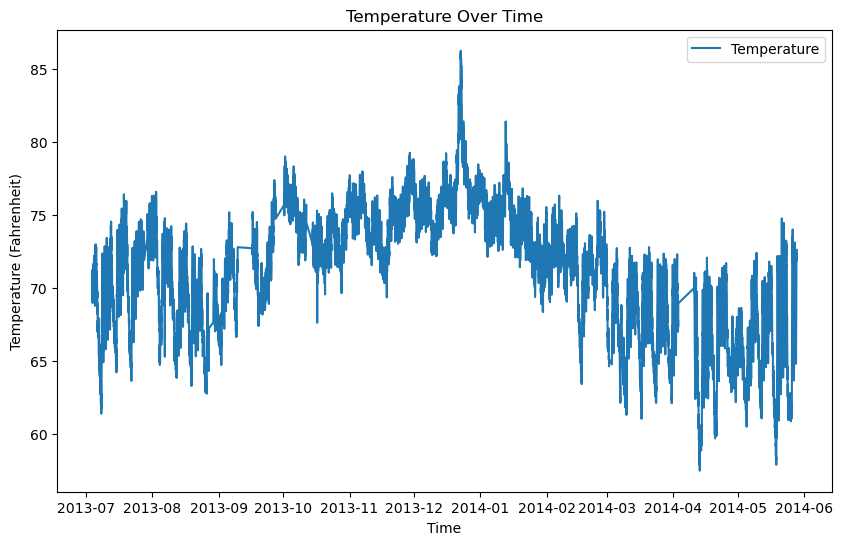

In [97]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['value'], label='Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (Fahrenheit)')
plt.legend()
plt.show()


# Feature Engineering

In [98]:
def classify_datetime(row):
    if row['dayofweek'] < 5:  # Weekdays
        if 7 <= row['hour'] <= 19:
            return 'Weekday Day'
        else:
            return 'Weekday Night'
    else:  # Weekend
        if 7 <= row['hour'] <= 19:
            return 'Weekend Day'
        else:
            return 'Weekend Night'

df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df['dtcat'] = df.apply(classify_datetime, axis=1)


# check added features in dataset

In [99]:
df.head()

,value,dayofweek,hour,dtcat
timestamp,,,,
2013-07-04 00:00:00,69.880835,3,0,Weekday Night
2013-07-04 01:00:00,71.220227,3,1,Weekday Night
2013-07-04 02:00:00,70.877805,3,2,Weekday Night
2013-07-04 03:00:00,68.959400,3,3,Weekday Night
2013-07-04 04:00:00,69.283551,3,4,Weekday Night


# K-means Clustering

[21800.999999999993, 15959.92595407463, 12246.070458235765, 9681.024799826802, 8384.613323374815, 6810.443645029583, 6083.720196278335, 5610.33565874379, 5137.187190847329, 4836.492943423165, 4530.867315832295, 4232.958609519437, 4059.439699306404, 3815.668498413151, 3678.2839522794497, 3526.010822901235, 3376.088132032652, 3233.2245477788383, 3145.5030260957487, 3017.0817619113914]


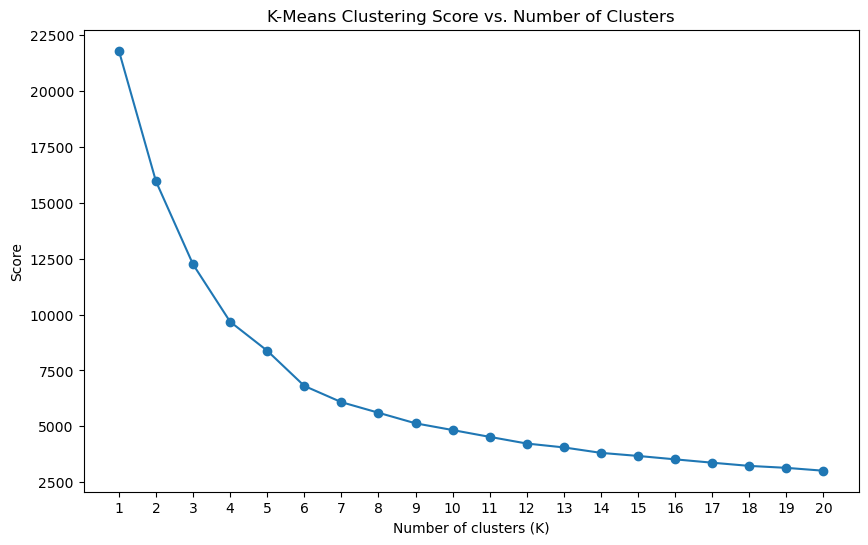

In [100]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Preprocessing
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['value', 'hour', 'dayofweek']]) 

# Find the best K
scores = []
K_range = range(1, 21)
for i in K_range:
    kmeans = KMeans(n_clusters=i, random_state=42).fit(df_scaled)
    scores.append(kmeans.inertia_)
    
print(scores)

plt.figure(figsize=(10, 6))
plt.plot(K_range, scores, marker='o')
plt.title('K-Means Clustering Score vs. Number of Clusters')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Score')
plt.xticks(K_range)
plt.show()


# PCA and Plotting Clusters

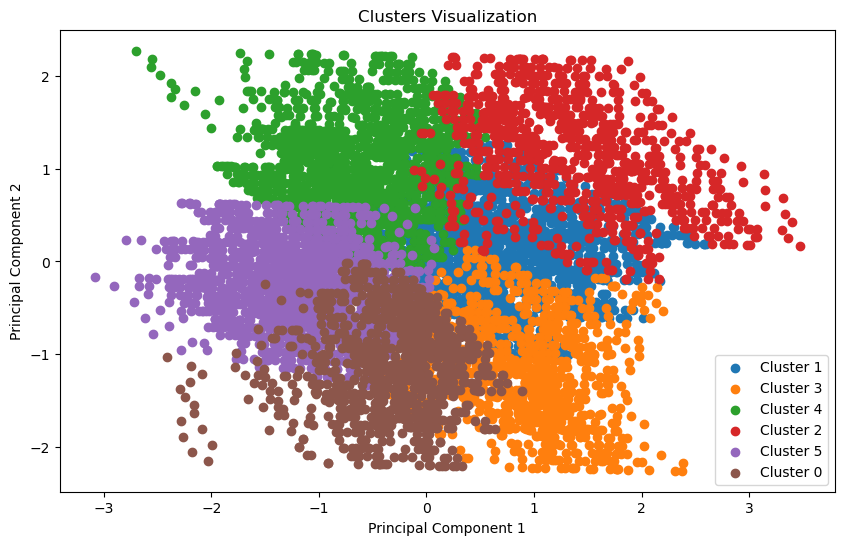

In [135]:
fit_K = 6
kmeans = KMeans(n_clusters=fit_K, random_state=42).fit(df_scaled)
df['cluster'] = kmeans.labels_

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
df_pca['cluster'] = df['cluster'].values

# Plot
plt.figure(figsize=(10, 6))
for cluster in df_pca['cluster'].unique():
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')
plt.title('Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()



# Checking Dataset

In [136]:
df.head()

,value,dayofweek,hour,dtcat,cluster,anomaly_envelope_fixed,anomaly_iso_forest_fixed,anomaly_envelope_iqr,anomaly_iso_forest_iqr
timestamp,,,,,,,,,
2013-07-04 00:00:00,69.880835,3,0,Weekday Night,1,1,1,1,1
2013-07-04 01:00:00,71.220227,3,1,Weekday Night,1,1,1,1,1
2013-07-04 02:00:00,70.877805,3,2,Weekday Night,1,1,1,1,1
2013-07-04 03:00:00,68.959400,3,3,Weekday Night,1,1,1,1,1
2013-07-04 04:00:00,69.283551,3,4,Weekday Night,1,1,1,1,1


# Checking PCA DataFrame

In [137]:
print(df_pca.head())

        PC1       PC2  cluster
0  1.166074 -1.000671        1
1  0.864782 -0.908383        1
2  0.839223 -0.822903        1
3  1.072048 -0.743804        1
4  0.937205 -0.655625        1


# Descriptive Statistics

In [138]:
print(df_pca[['PC1', 'PC2']].describe())

               PC1           PC2
count  7267.000000  7.267000e+03
mean      0.000000  4.888831e-18
std       1.078766  9.952970e-01
min      -3.080871 -2.257061e+00
25%      -0.814585 -7.223392e-01
50%      -0.048035  1.105980e-03
75%       0.796972  7.225980e-01
max       3.467813  2.272812e+00


# Anomaly Detection using Assumption

In [139]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

# Provided outliers_fraction
outliers_fraction_fixed = 0.01

# EllipticEnvelope with fixed outliers_fraction
envelope_fixed = EllipticEnvelope(contamination=outliers_fraction_fixed)
envelope_fixed.fit(df_scaled)
df['anomaly_envelope_fixed'] = envelope_fixed.predict(df_scaled)

# Isolation Forest with fixed outliers_fraction
iso_forest_fixed = IsolationForest(contamination=outliers_fraction_fixed)
iso_forest_fixed.fit(df_scaled)
df['anomaly_iso_forest_fixed'] = iso_forest_fixed.predict(df_scaled)


# Anomaly Detection using IQR

In [140]:
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1

cutoff = IQR * 1.5
lower_bound = Q1 - cutoff
upper_bound = Q3 + cutoff

# Calculate outliers fraction
outliers_df = df[(df['value'] < lower_bound) | (df['value'] > upper_bound)]
outliers_fraction_iqr = len(outliers_df) / len(df)
print(outliers_fraction_iqr)

# EllipticEnvelope with IQR outliers_fraction
envelope_iqr = EllipticEnvelope(contamination=outliers_fraction_iqr)
envelope_iqr.fit(df_scaled)
df['anomaly_envelope_iqr'] = envelope_iqr.predict(df_scaled)

# Isolation Forest with IQR outliers_fraction
iso_forest_iqr = IsolationForest(contamination=outliers_fraction_iqr)
iso_forest_iqr.fit(df_scaled)
df['anomaly_iso_forest_iqr'] = iso_forest_iqr.predict(df_scaled)


0.004816292830604101


# Checking DataFrame

In [141]:
df.head()

,value,dayofweek,hour,dtcat,cluster,anomaly_envelope_fixed,anomaly_iso_forest_fixed,anomaly_envelope_iqr,anomaly_iso_forest_iqr
timestamp,,,,,,,,,
2013-07-04 00:00:00,69.880835,3,0,Weekday Night,1,1,1,1,1
2013-07-04 01:00:00,71.220227,3,1,Weekday Night,1,1,1,1,1
2013-07-04 02:00:00,70.877805,3,2,Weekday Night,1,1,1,1,1
2013-07-04 03:00:00,68.959400,3,3,Weekday Night,1,1,1,1,1
2013-07-04 04:00:00,69.283551,3,4,Weekday Night,1,1,1,1,1


# Plotting Anomalies

In [142]:
def plot_anomalies(df, temperature_col, anomaly_col, title):
    plt.figure(figsize=(10, 6))
    plt.plot(df[temperature_col], color='Green', label='Normal')
    plt.scatter(df.index[df[anomaly_col] == -1], df[temperature_col][df[anomaly_col] == -1], color='red', label='Anomaly')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()
    
    
    # List anomalies
    anomalies = df[df[anomaly_col] == -1][temperature_col]
    
    # print the sum of anomalies
    total_anomalies = anomalies.count()
    print("Sum of anomalies:", total_anomalies)




## Elliptic Envelope with Assumption

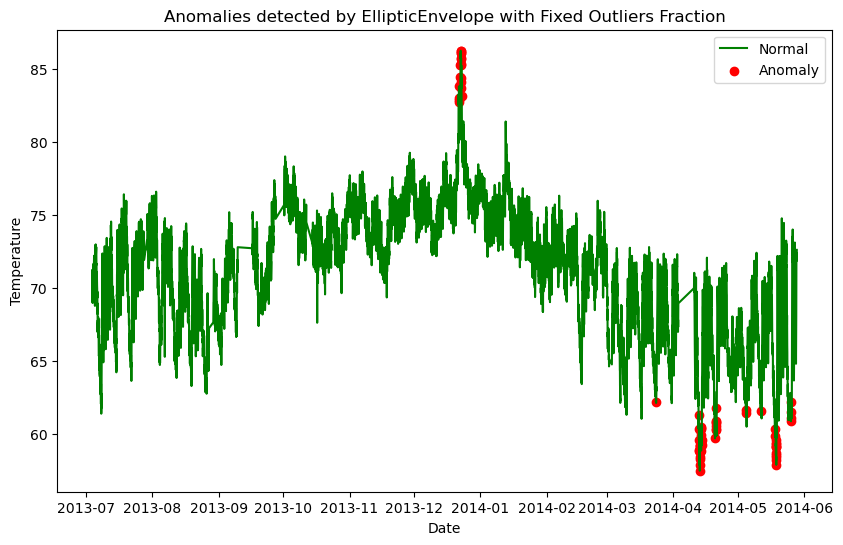

Sum of anomalies: 73


In [143]:
# Plot anomalies for EllipticEnvelope with fixed outliers_fraction
plot_anomalies(df, 'value', 'anomaly_envelope_fixed', 'Anomalies detected by EllipticEnvelope with Fixed Outliers Fraction')

## Isolation Forest with Assumption

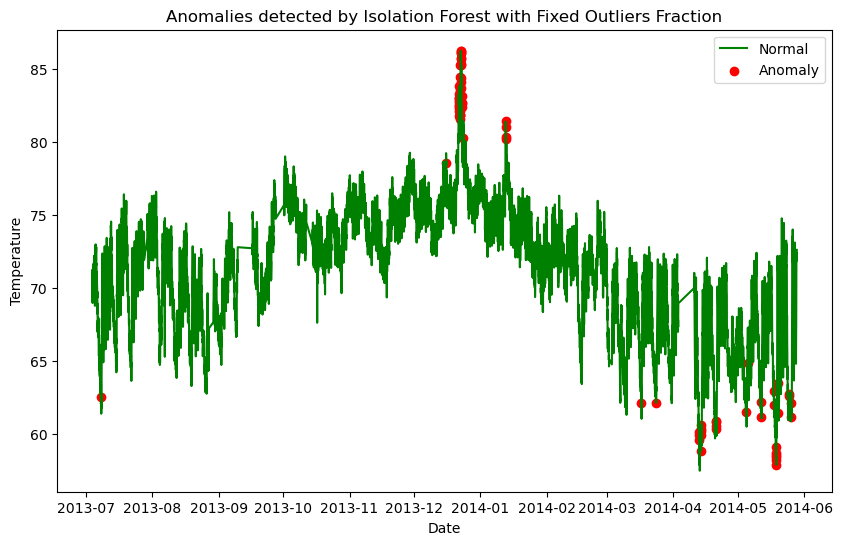

Sum of anomalies: 73


In [144]:
# Plot anomalies for Isolation Forest with fixed outliers_fraction
plot_anomalies(df, 'value', 'anomaly_iso_forest_fixed', 'Anomalies detected by Isolation Forest with Fixed Outliers Fraction')

## EllipticEnvelope with IQR Fraction

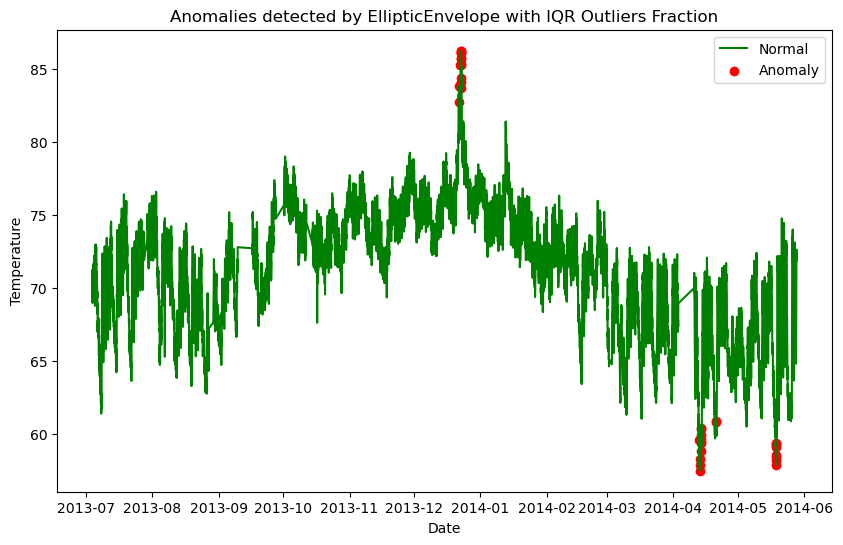

Sum of anomalies: 35


In [145]:
# Plot anomalies for EllipticEnvelope with IQR outliers_fraction
plot_anomalies(df, 'value', 'anomaly_envelope_iqr', 'Anomalies detected by EllipticEnvelope with IQR Outliers Fraction')

## Isolation Forest with IQR Fraction

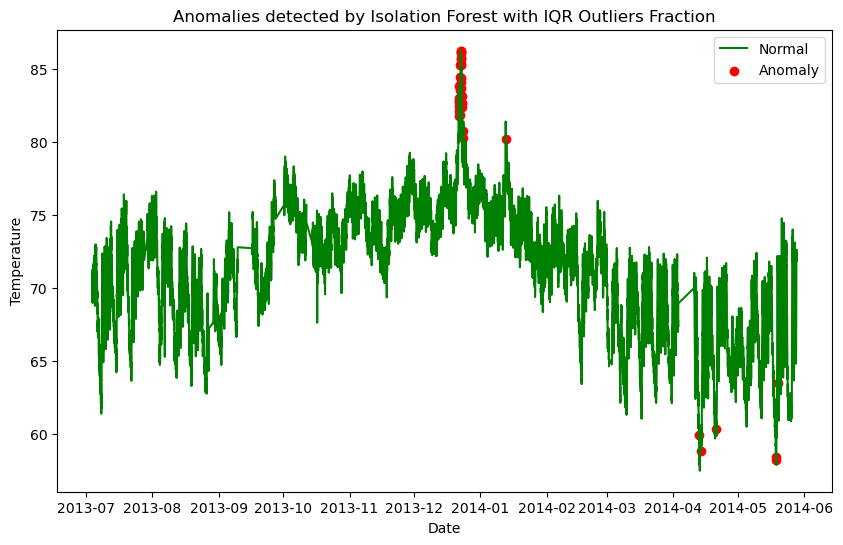

Sum of anomalies: 35


In [146]:
# Plot anomalies for Isolation Forest with IQR outliers_fraction
plot_anomalies(df, 'value', 'anomaly_iso_forest_iqr', 'Anomalies detected by Isolation Forest with IQR Outliers Fraction')

# See if all anomalies are same in both

In [147]:
anomalies_elliptic = set(df[df['anomaly_envelope_iqr'] == -1].index)
anomalies_iso_forest = set(df[df['anomaly_iso_forest_iqr'] == -1].index)

# Check if the sets of anomalies are the same
print("Anomalies are identical:", anomalies_elliptic == anomalies_iso_forest)


Anomalies are identical: False


# Find number of common anomalies

In [148]:
# Find indices of anomalies detected by EllipticEnvelope
anomalies_envelope_indices = df[df['anomaly_envelope_iqr'] == -1].index

# Find indices of anomalies detected by IsolationForest
anomalies_iso_indices = df[df['anomaly_iso_forest_iqr'] == -1].index

# Convert indices to sets and find the intersection
common_anomalies_indices = set(anomalies_envelope_indices).intersection(set(anomalies_iso_indices))

# Print the number of common anomalies
print("Number of common anomalies detected by both models:", len(common_anomalies_indices))


Number of common anomalies detected by both models: 17


# K-Fold Cross Validation

## Isolation Forest with fixed

In [149]:
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

anomaly_scores_iso_forest = []

for train_index, test_index in kf.split(df_scaled): 
    X_train, X_test = df_scaled[train_index], df_scaled[test_index] 
    iso_forest = IsolationForest(contamination=outliers_fraction_fixed, random_state=42)
    iso_forest.fit(X_train)
    scores = iso_forest.decision_function(X_test)
    anomaly_scores_iso_forest.extend(scores)

anomaly_scores_variance = np.var(anomaly_scores_iso_forest)

# Display the variance of the anomaly scores across the folds
anomaly_scores_variance


0.001913281695304691

## Elliptic Envelope with fixed

In [150]:
# List to store the anomaly scores for each fold for Elliptic Envelope model
anomaly_scores_elliptic_envelope = []

envelope = EllipticEnvelope(contamination=outliers_fraction_fixed, random_state=42)
envelope.fit(X_train)
    
# Calculate anomaly scores (the higher, the more abnormal)
scores = envelope.decision_function(X_test)
    
# Store the scores (we invert the scores here because for Elliptic Envelope, 
# higher values are more anomalous, which is opposite to Isolation Forest)
anomaly_scores_elliptic_envelope.extend(-scores)

# Now, we can calculate the variance of the scores for the Elliptic Envelope model
anomaly_scores_variance_envelope = np.var(anomaly_scores_elliptic_envelope)

# Display the variance of the anomaly scores across the folds for the Elliptic Envelope model
anomaly_scores_variance_envelope


8.469462937630519

## Elliptic Envelope & Isolation Forest with IQR

In [151]:
outliers_fraction_iqr_corrected = outliers_fraction_iqr

anomaly_scores_iso_forest_iqr = []
anomaly_scores_elliptic_envelope_iqr = []

# Repeating K-Fold Cross Validation with the IQR-based outliers fraction
for train_index, test_index in kf.split(df_scaled):
    X_train, X_test = df_scaled[train_index], df_scaled[test_index]
    
    # Isolation Forest with corrected IQR-based outliers fraction
    iso_forest_iqr_corrected = IsolationForest(contamination=outliers_fraction_iqr_corrected, random_state=42)
    iso_forest_iqr_corrected.fit(X_train)
    scores_iso_iqr_corrected = iso_forest_iqr_corrected.decision_function(X_test)
    anomaly_scores_iso_forest_iqr.extend(scores_iso_iqr_corrected)
    
    # Elliptic Envelope with corrected IQR-based outliers fraction
    envelope_iqr_corrected = EllipticEnvelope(contamination=outliers_fraction_iqr_corrected, random_state=42)
    envelope_iqr_corrected.fit(X_train)
    scores_envelope_iqr_corrected = envelope_iqr_corrected.decision_function(X_test)
    anomaly_scores_elliptic_envelope_iqr.extend(-scores_envelope_iqr_corrected)

# variances of the scores 
variance_iso_forest_iqr_corrected = np.var(anomaly_scores_iso_forest_iqr)
variance_envelope_iqr_corrected = np.var(anomaly_scores_elliptic_envelope_iqr)

outliers_fraction_iqr_corrected, variance_iso_forest_iqr_corrected, variance_envelope_iqr_corrected


(0.004816292830604101, 0.001928726012673266, 8.182690223973102)

## Isolation Forest is best method for anomalies detection
As we see variance in data in two models by considering fixed anomalies fraction and IQR based anomalies fraction,irrespective of those, isolation forest model shows less variance when compared with elliptic envelope model. isolation anomaly scores are very consistent across different folds. The model provides stable performance regardless of how the data is split, indicating it is likely to perform similarly on unseen data. Higher variance in elliptic model indicates there's more fluctuation in the model's anomaly scores across different folds. The model's performance is less consistent, which might suggest it is more sensitive to the specific data it's trained on. This could lead to less predictable performance on new data.